In [29]:
import os
import csv
import math
import random
import string
import functools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor

from keras.models import Sequential
from keras.layers import Dense

from objects.Plane import Plane
from objects.Maneuvers import Wheel, ShowOfForce, Mission_Maneuver, Maneuver_Mission

from function import tools 
from function.tools import KNOTS2KMH, KMH2KNOTS


# WARNING : Values are wrong, this is just a sketch

# FUEL_CONSUMPTION_RATE =  3 #2.5 # KG / KM for a 100 knots speed for X plane model
pd.reset_option('display.max_colwidth')


In [30]:

list_maneuvers = [
    Wheel('FastFullWheel', 350, 1, 10, 100),
    # Wheel('FastQuarterWheel', 350, 1, 2, 50),
    # Wheel('FastHalfWheel', 350, 1, 6, 75),
    Wheel('NormalFullWheel', 240, 1, 10,  85),
    # Wheel('NormalQuarterWheel', 240, 1, 2, 40),
    # Wheel('NormalHalfWheel', 240, 1, 6, 75),
    Wheel('FullLowWheel', 240, 0.5, 10, 75),
    # Wheel('QuarterLowWheel', 240, 0.5, 2, 30),
    # Wheel('HalfLowWheel', 240, 0.5, 6, 50),
    Wheel('LargeFullWheel', 350, 1, 14, 95),
    # Wheel('NormalFullWheel',250, 1, 8, ['CAS', 'SCAR']), Wheel('NormalQuarterWheel', 250, 1, 4, ['CAS', 'SCAR']),
    # Wheel('NormalHalfWheel', 250, 1, 4, ['CAS', 'SCAR']), Wheel('NormalLowFullWheel',250, 0.5, 8, ['CAS', 'SCAR']),
    # Wheel('NormalLowQuarterWheel', 250, 0.5, 4, ['CAS', 'SCAR']), Wheel('NormalLowHalfWheel', 250, 0.5, 4, ['CAS', 'SCAR']),
    Wheel('SlowFullWheel', 180, 1, 10, 65),
    # Wheel('SlowHalfWheel', 180, 1, 6, 50),
    # Wheel('SlowQuarterWheel', 180, 1, 2, 25),
    Wheel('SlowLowFullWheel', 180, 1, 10, 40),
    # Wheel('SlowLowHalfWheel', 180, 1, 6, 30),
    # Wheel('SlowLowQuarterWheel', 180, 1, 2, 20),
    Wheel('HighFullWheel', 240, 1.5, 10, 90),
    # Wheel('HighHalfWheel', 240, 1.5, 6, 75),
    # Wheel('HighQuarterWheel', 240, 1.5, 2, 50),
    ShowOfForce('ClassicShowOfForce', 500, 0.3, 10, 100),
]


In [31]:
dic_maneuvers = dict()

for i in range(len(list_maneuvers)):
    dic_maneuvers[i] = list_maneuvers[i]


In [32]:
print(dic_maneuvers)
print(Maneuver_Mission.ShowOfForce)

{0: FastFullWheel, 1: NormalFullWheel, 2: FullLowWheel, 3: LargeFullWheel, 4: SlowFullWheel, 5: SlowLowFullWheel, 6: HighFullWheel, 7: ClassicShowOfForce}
Maneuver_Mission.ShowOfForce


In [33]:
TF51D = Plane()
M2000 = Plane('M2000', 2, 3200, 532, 2340 * KMH2KNOTS)
ULM = Plane('ULM', 0.1, 130, 150 * KMH2KNOTS, 200 * KMH2KNOTS)
plane_list = [TF51D, M2000, ULM]

Cet avion peut voler pendant  963  s, soit  16  min à une vitesse moyenne de  444  km/h et sa vitesse max sera de  898  km/h
Cet avion peut voler pendant  1600  s, soit  27  min à une vitesse moyenne de  985  km/h et sa vitesse max sera de  2340  km/h
Cet avion peut voler pendant  1300  s, soit  22  min à une vitesse moyenne de  150  km/h et sa vitesse max sera de  200  km/h


In [34]:
print("Voila le coût en fuel des manoeuvres : ")
for plane in plane_list:
    print("Plane : ", plane)
    for man in list_maneuvers:
        print(man.total_fuel_consumption(plane),
              " kg for this maneuver | ", man.travelled_time(), " seconds for this maneuver, so ", math.floor(man.travelled_time() / 60), " min ", round(man.travelled_time() % 60, 2), " seconds")


Voila le coût en fuel des manoeuvres : 
Plane :  TF51D
42.16216216216217  kg for this maneuver |  48.11468312987374  seconds for this maneuver, so  0  min  48.11  seconds
42.16216216216217  kg for this maneuver |  70.1827727007583  seconds for this maneuver, so  1  min  10.18  seconds
168.64864864864867  kg for this maneuver |  70.1827727007583  seconds for this maneuver, so  1  min  10.18  seconds
59.02702702702703  kg for this maneuver |  65.87054009658151  seconds for this maneuver, so  1  min  5.87  seconds
42.16216216216216  kg for this maneuver |  93.56982306047054  seconds for this maneuver, so  1  min  33.57  seconds
42.16216216216216  kg for this maneuver |  93.56982306047054  seconds for this maneuver, so  1  min  33.57  seconds
18.73873873873874  kg for this maneuver |  70.1827727007583  seconds for this maneuver, so  1  min  10.18  seconds
249.84984984984987  kg for this maneuver |  38.36062886959905  seconds for this maneuver, so  0  min  38.36  seconds
Plane :  M2000
73.0

In [35]:
param_list = {
    'Plane': plane_list,
    'GoalDistance': [0, 10, 15, 20, 30],
    'RtBDistance': [0, 10, 15, 20, 30],
    'Fuel': [300, 400, 400, 450, 500, 550],
    'MaxSpeedOP': [250, 300, 350, 400],
    # Start with just 2 states : good (sunny, no clouds) and bad (cloudy or rainy)
    'Meteo': ["Sunny", "Cloudy", "Misty"],
    'MissionType': [Mission_Maneuver.SCAR],  # , Mission_Maneuver.CAS
    'TimeMin' : [None, 300],
    # Add ennemies number afterwards, weaponry
    'Strength': ['Weak', 'Equal', 'Strong'],
    # '' : [90,0,50]
}


In [36]:

all_combinations_not_filtered = tools.get_all_combinations(param_list)
all_combinations = []
for c in all_combinations_not_filtered:
    data = c['metadata']

    plane = data['Plane']
    if plane.name == 'M2000':
        data['Fuel'] *= 6
    elif plane.name == 'ULM':
        data['Fuel'] /= 6
    # Check if the data corresponds to the plane caracteristics
    if plane.fuel_max >= data['Fuel'] :
        if plane.V_max < data['MaxSpeedOP']:
            data['MaxSpeedOP'] = plane.V_max
        all_combinations.append(data)


In [37]:
print(len(all_combinations))
print(len(all_combinations_not_filtered))
print(pd.DataFrame(all_combinations).sample(10))

28800
32400
       Plane  GoalDistance  RtBDistance         Fuel  MaxSpeedOP   Meteo  \
18268    ULM             0            0    75.000000    107.9914   Misty   
11223  M2000            10           10  1800.000000    400.0000  Cloudy   
23036    ULM            15           10    75.000000    107.9914   Misty   
4391   TF51D            15           15   300.000000    400.0000   Misty   
6155   TF51D            20           15   300.000000    300.0000   Misty   
13829  M2000            15           20  2400.000000    250.0000   Sunny   
8782   TF51D            30           30   400.000000    400.0000   Misty   
20582    ULM            10            0    91.666667    107.9914  Cloudy   
19964    ULM             0           30    75.000000    107.9914   Sunny   
14355  M2000            15           30  3000.000000    300.0000  Cloudy   

      MissionType  TimeMin Strength  
18268        SCAR    300.0    Equal  
11223        SCAR    300.0     Weak  
23036        SCAR      NaN   Strong  

In [38]:
for c in all_combinations:
    plane = c['Plane']
    fcr = plane.fuel_consumption_rate
    speed = c['MaxSpeedOP'] * KNOTS2KMH
    c['FuelRemaining'] = c['Fuel'] - (fcr * (c['GoalDistance'] / speed) * 3600) - (
        fcr * (c['RtBDistance'] / speed) * 3600)
    # c['BaseFuelRemaining'] = c['FuelRemaining']


In [39]:
def choose_randomly(maneuvers_for_c, c) -> list:
    percent = math.ceil(random.random() * 100)
    # percent = math.ceil(random.gauss(50,(50-5)/3))
    if percent < 0:
        percent += 100
    elif percent > 100:
        percent -= 100
    max_speed = c['MaxSpeedOP']
    new_maneuvers = []
    new_maneuvers = filter(
        lambda m: dic_maneuvers[m].meanspeed <= max_speed, maneuvers_for_c)
    if c['Strength'] == 'Weak' or c['Strength'] == 'Equal':
        if percent <= 95:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].meanspeed >= 200, new_maneuvers)
        else:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].meanspeed < 200, new_maneuvers)
    elif c['Strength'] == 'Strong':
        if percent <= 95:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].meanspeed < 200, new_maneuvers)
        else:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].meanspeed >= 200, new_maneuvers)

    if c['Meteo'] == "Cloudy" or c['Meteo'] == 'Misty':
        if percent <= 95:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].altitude < 1, new_maneuvers)
        else:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].altitude >= 1, new_maneuvers)
    else:
        if percent <= 95:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].altitude >= 1, new_maneuvers)
        else:
            new_maneuvers = filter(
                lambda m: dic_maneuvers[m].altitude < 1, new_maneuvers)
    return list(new_maneuvers)


In [40]:
def select_maneuvers(maneuvers_for_c, c):
    selected = []
    minCost = min(dic_maneuvers[man].total_fuel_consumption(
        c['Plane']) for man in maneuvers_for_c)
    minEfficiency = min(
        dic_maneuvers[man].efficiency for man in maneuvers_for_c)
    efficiency = 90
    while c['FuelRemaining'] >= minCost and efficiency >= minEfficiency and len(selected) < 5:
        maneuvers_with_eff = list(filter(
            lambda man: dic_maneuvers[man].efficiency >= efficiency, maneuvers_for_c))
        if len(maneuvers_with_eff) != 0:
            rand = random.randint(0, len(maneuvers_with_eff)-1)
            man = dic_maneuvers[maneuvers_with_eff[rand]]
            if (c['FuelRemaining'] - man.total_fuel_consumption(c['Plane'])) >= 0:
                c['FuelRemaining'] -= man.total_fuel_consumption(c['Plane'])
                selected.append(maneuvers_with_eff[rand])
            else:
                efficiency -= 5
        else:
            efficiency -= 5
    return selected


In [41]:
indexed_maneuvers = list_maneuvers.copy()

p = True
combinations = all_combinations.copy()
count = 0
all_maneuvers_for_c = []
for c in combinations:
    maneuvers_for_c = list(filter(
        lambda m:  dic_maneuvers[m].name in c['MissionType'].getManeuver(), dic_maneuvers))
    maneuvers_for_c = list(filter(lambda m: dic_maneuvers[m].total_fuel_consumption(
        c['Plane']) < c['FuelRemaining'], maneuvers_for_c))
    maneuvers_for_c = choose_randomly(maneuvers_for_c, c)
    all_maneuvers_for_c.append(maneuvers_for_c)


In [42]:
final_combinations = combinations.copy()
for c, maneuvers_for_c in zip(final_combinations, all_maneuvers_for_c):
    if len(maneuvers_for_c) > 0:
        maneuvers = select_maneuvers(maneuvers_for_c, c)
        if maneuvers != None or len(maneuvers) > 0:
            c['Maneuvers'] = list(maneuvers)
            c['TimeOfMission'] = sum(
                dic_maneuvers[m].travelled_time() for m in c['Maneuvers'])


In [43]:
# print(impossible_combinations)
final_combinations_plane = [
    c for c in final_combinations if c.get("Maneuvers")]
# print(len(final_combinations), len(final_combinations_plane))
# for c in final_combinations_plane:
#     # c['Maneuvers'] = [c.__dict__ for c in c['Maneuvers']]
#     # c['Plane'] = c['Plane']

final_combinations_maneuvers = final_combinations_plane.copy()
# final_combinations_maneuvers = final_combinations.copy()
list_maneuvers = []

for c in final_combinations_maneuvers:
    list_maneuvers.append(c['Maneuvers'])

print(len(list_maneuvers))
first_tuple_list = []
for lst in list_maneuvers:
    first_tuple_list.append(tuple(lst))
print("Done")
set_man = set(first_tuple_list)
new_dict = dict()

for i in range(len(set_man)):
    new_dict[set_man.pop()] = i
print(len(new_dict))


13805
Done
296


In [44]:
# print(dic_maneuvers.get(i))

for c in final_combinations_maneuvers:
    c['Maneuvers'] = new_dict.get(tuple(c['Maneuvers']))
df = pd.DataFrame(final_combinations_maneuvers)


In [45]:

df.sample(10)


,Plane,GoalDistance,RtBDistance,Fuel,MaxSpeedOP,Meteo,MissionType,TimeMin,Strength,FuelRemaining,Maneuvers,TimeOfMission
3259,TF51D,15,10,450,350,Misty,SCAR,300.0,Equal,40.502764,104,140.365545
9927,M2000,15,10,1800,400,Cloudy,SCAR,NaN,Equal,95.090504,23,350.913864
12292,M2000,20,30,2700,250,Sunny,SCAR,300.0,Strong,1556.979970,191,467.849115
6870,M2000,0,0,2400,300,Sunny,SCAR,300.0,Strong,2034.517766,191,467.849115
12782,M2000,30,10,2400,400,Sunny,SCAR,NaN,Strong,1645.748868,191,467.849115
2173,TF51D,10,15,450,400,Cloudy,SCAR,300.0,Equal,49.527757,104,140.365545
375,TF51D,0,10,400,400,Sunny,SCAR,NaN,Strong,163.919211,191,467.849115
8344,M2000,10,0,2400,350,Cloudy,SCAR,NaN,Equal,826.994238,23,350.913864
4473,TF51D,20,10,300,400,Sunny,SCAR,300.0,Weak,28.370245,257,267.794393
9567,M2000,10,30,3000,300,Misty,SCAR,NaN,Weak,1019.712535,23,350.913864


In [46]:

df.describe()


,GoalDistance,RtBDistance,Fuel,MaxSpeedOP,TimeMin,FuelRemaining,Maneuvers,TimeOfMission
count,13805.000000,13805.000000,13805.000000,13805.000000,6879.0,13805.000000,13805.000000,13805.000000
mean,14.884824,14.868888,1452.404926,325.552336,300.0,650.710662,125.124520,292.793232
std,9.979394,9.977927,1062.761555,55.847513,0.0,727.713783,74.161859,128.576407
min,0.000000,0.000000,300.000000,250.000000,300.0,0.124386,0.000000,70.182773
25%,10.000000,10.000000,400.000000,300.000000,300.0,97.658047,23.000000,140.365545
50%,15.000000,15.000000,1800.000000,350.000000,300.0,235.010410,136.000000,350.913864
75%,20.000000,20.000000,2400.000000,400.000000,300.0,1100.706055,191.000000,350.913864
max,30.000000,30.000000,3000.000000,400.000000,300.0,2837.563452,295.000000,467.849115


In [47]:
pd.set_option('display.max_colwidth', None)
df.sample(1).get("Maneuvers")
pd.reset_option('display.max_colwidth')


In [48]:


df = pd.get_dummies(df, columns=["Plane", "Meteo", "MissionType", "Strength", 'TimeMin'])
df.sample(10)
# data_MissionType = pd.DataFrame(ohe.fit_transform(data_meteo[["MissionType"]]))
# data_Strength = pd.DataFrame(ohe.fit_transform(data_MissionType[["Strength"]]))
# data_Strength


,GoalDistance,RtBDistance,Fuel,MaxSpeedOP,FuelRemaining,Maneuvers,TimeOfMission,Plane_TF51D,Plane_M2000,Meteo_Cloudy,Meteo_Misty,Meteo_Sunny,MissionType_SCAR,Strength_Equal,Strength_Strong,Strength_Weak,TimeMin_300.0
2487,10,20,500,350,202.549263,191,467.849115,1,0,0,0,1,1,0,1,0,0
9713,15,0,2400,250,704.809727,23,350.913864,0,1,1,0,0,1,1,0,0,0
7783,0,20,2400,350,1904.952943,2,324.533541,0,1,1,0,0,1,0,1,0,0
13732,30,30,2700,350,1668.056798,191,467.849115,0,1,0,1,0,1,1,0,0,1
5978,30,10,450,400,168.091258,90,302.465452,1,0,0,0,1,1,0,0,1,0
7445,0,15,2400,350,771.455824,23,350.913864,0,1,1,0,0,1,1,0,0,1
1389,0,30,500,400,86.892767,104,140.365545,1,0,0,1,0,1,1,0,0,0
5481,20,30,500,350,18.302826,104,140.365545,1,0,0,1,0,1,1,0,0,0
12712,30,10,1800,350,1001.581012,179,280.397362,0,1,0,0,1,1,1,0,0,0
195,0,0,450,350,239.189189,191,467.849115,1,0,0,0,1,1,0,1,0,1


In [49]:
df_first = df.copy()
X_train, X_test, y_train, y_test = train_test_split(df_first.drop(
    "TimeOfMission", axis=1), df_first["TimeOfMission"], test_size=0.15)
# X_train, X_test, y_train, y_test = train_test_split( df.drop("Maneuvers", axis=1), df["Maneuvers"], test_size=0.30)
models = [Lasso(), KNeighborsRegressor(), RandomForestRegressor(),
          GradientBoostingRegressor()]

once = True
for model in models:

    # Model is trained with the corrupted / imputed data
    model.fit(X_train, y_train)

    # Model performance is evaluated against the original test dataset
    y_pred = model.predict(X_test)
    # y_pred = [round(y) for y in y_pred]
    score = r2_score(y_test, y_pred)
    if not once:
        for t, p in zip(y_test, y_pred):
            print(t, p)
        once = True
    print(model, score)


Lasso() 0.7229462536532477
KNeighborsRegressor() 0.9441928350374166
RandomForestRegressor() 0.9959062412574353
GradientBoostingRegressor() 0.9936207474061899


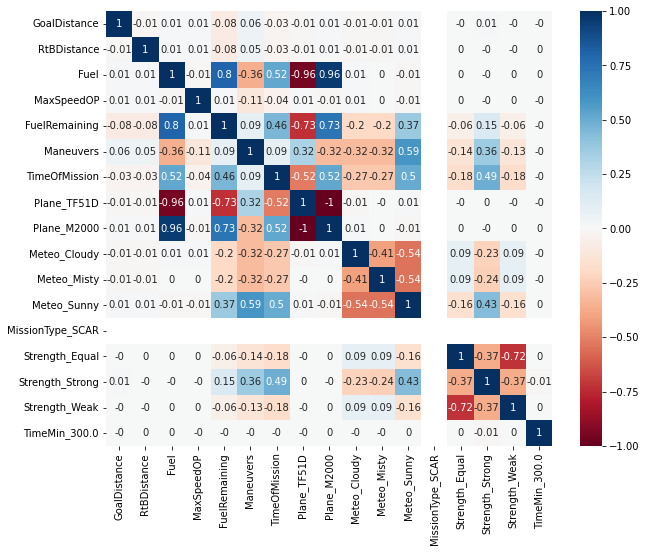

In [50]:
tools.showMatrix(df_first)

In [51]:

df_second = df.copy()
# , df_second["Maneuvers"],]
X_train, X_test, y_train, y_test = train_test_split(df_second.drop(
    ["TimeOfMission", "Maneuvers", "FuelRemaining"], axis=1), df_second["TimeOfMission"], test_size=0.30)
# X_train, X_test, y_train, y_test = train_test_split( df.drop("Maneuvers", axis=1), df["Maneuvers"], test_size=0.30)
models = [Lasso(), KNeighborsRegressor(), RandomForestRegressor(
    n_estimators=100), GradientBoostingRegressor(), DecisionTreeRegressor(max_depth=5)]

print(X_train.columns)


Index(['GoalDistance', 'RtBDistance', 'Fuel', 'MaxSpeedOP', 'Plane_TF51D',
       'Plane_M2000', 'Meteo_Cloudy', 'Meteo_Misty', 'Meteo_Sunny',
       'MissionType_SCAR', 'Strength_Equal', 'Strength_Strong',
       'Strength_Weak', 'TimeMin_300.0'],
      dtype='object')


In [52]:

for model in models:
    # Model is trained with the corrupted / imputed data
    model.fit(X_train, y_train)

once = True
dim = X_train.shape[1]
epochs = 50
activation_names = ["relu", "sigmoid", "tanh"]
# for activation in activation_names :
#     model = Sequential()
#     #On pourrait essayer de rajouter plusieurs paramètres de modèles différents notamment en rajoutant des couches supplémentaires ou en utilisant un nombre de neurones cachés différent. Nous allons nous contenter ici de seulement changer la fonction d'activation.
#     model.add(Dense(150, input_dim= dim, activation=activation))
#     #On peut essayer d'ajouter une couche intermédiaire, mais la performance ne sera pas assez intéressante
#     #model.add(Dense(300, activation=name))
#     model.add(Dense(150, activation=activation))

#     # Vu que l'on utilise une régression pour un prix, on utilise une fonction d'activation linéaire pour la sortie
#     model.add(Dense(1, activation='linear'))
#     model.compile(loss='mean_squared_error', optimizer='adam')

#     #visualize_model(X_train, X_test, y_train, y_test, model, show_pred_vs_y_test=True)
#     model.fit(X_train, y_train,epochs=epochs, verbose = 0)

#     models.append(model)
scores = []
for model in models:

    # Model performance is evaluated against the original test dataset
    y_pred = model.predict(X_test)
    # y_pred = [round(y) for y in y_pred]
    scores.append(r2_score(y_test, y_pred))
    if not once:
        for t, p, x in zip(y_test, y_pred, X_test.values):
            print(t, p, x)
        once = True


In [53]:
for model, score in zip(models, scores):
    print(model, score)


Lasso() 0.6237522326446298
KNeighborsRegressor() 0.5707193588113386
RandomForestRegressor() 0.8198155710946002
GradientBoostingRegressor() 0.8430910162190676
DecisionTreeRegressor(max_depth=5) 0.8356640318618941


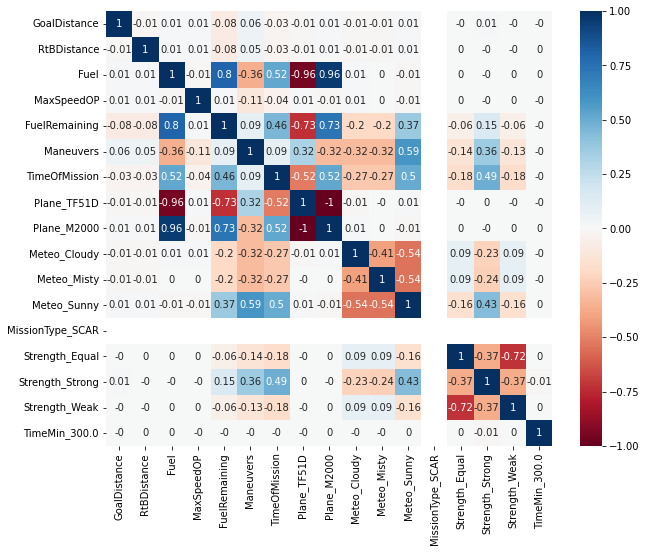

In [54]:
tools.showMatrix(df_second)



In [55]:
# Export as dot file
# export_graphviz(models[4], out_file='tree.dot',
#                 feature_names=df_second.drop(
#                     ["TimeOfMission", "FuelRemaining", "Maneuvers"], axis=1).columns,
#                 class_names="TimeOfMission",
#                 rounded=True, proportion=False,
#                 precision=6, filled=True)
# os.system('dot -Tpng tree.dot -o tree.png')
# Display in jupyter notebook


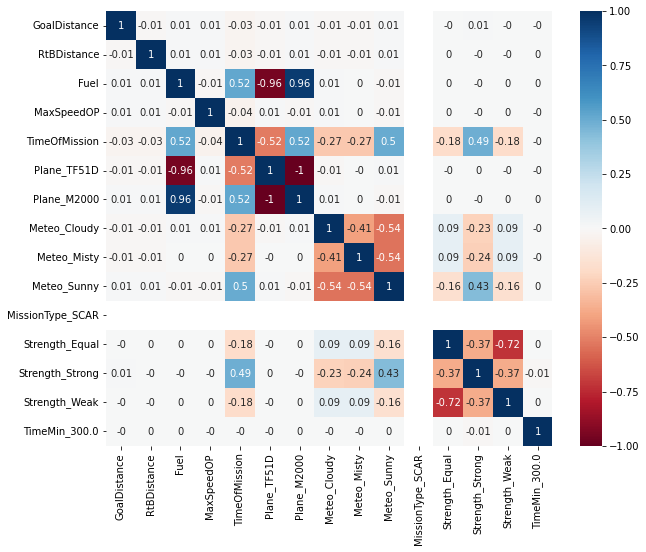

In [56]:

tools.showMatrix(df_second.drop(
    ["Maneuvers", "FuelRemaining"], axis=1))